<img src="img/vs265header.svg"/>

<h1 align="center">Lab 2 - Supervised Learning <font color="red">  </font> </h1>

<h2 align="center">1. Linear Neuron with sigmoidal output nonlinearity </h2> 

Derive the modified learning rule for a linear neuron with sigmoidal output nonlinearity:

$$y= \sigma(u) = \frac{1}{1 + e^{-u}}$$
with $u = w^T x = \sum_i w_i x_i$

$$ \text{*Your LATEX here*} $$

We start with the energy function

$E = -\frac{1}{2} \sum\limits_{\alpha}{\left( T^{(\alpha)} - y^{(\alpha)} \right)^2}$

We want to minimize energy function

Take derivative with respect to input weights

$\frac{\partial{E}}{\partial{w_i}} = \sum\limits_{\alpha}{\left( T^{(\alpha)} - y^{(\alpha)}\right) \frac{\partial{y}}{\partial{w_i}} }$

So we want $\frac{\partial{y}}{\partial{w_i}}$

Well, $y = \sigma(u) = \frac{1}{1+e^{-u}}$

and $u$ is a function of $w_i$, and $\frac{\partial{u}}{\partial{w_i}}$ is $x_i$ (the only term in the sum that depends on $w_i$)

$\frac{\partial{y}}{\partial{w_i}} = \frac{1}{\left( 1 + e^{-u} \right)^2} e^{-u} \frac{\partial{u}}{\partial{w_i}}$

$\frac{\partial{y}}{\partial{w_i}} = y^2 e^{-u} x_i$

Then

$\frac{\partial{E}}{\partial{w_i}} = \sum\limits_{\alpha}{\left( T^{(\alpha)} - y^{(\alpha)}\right)  y^2 e^{-u} x_i }$

A gradient descent step updates the weight $w_i$ proportinally to that gradient scaled by a learning rate $\eta$

$\Delta{w_i} = \eta \sum\limits_{\alpha}{\left( T^{(\alpha)} - y^{(\alpha)}\right)  y^2 e^{-u} x_i } $

<h2 align="center">2. Single layer network </h2> 

Train a single neuron to discriminate between the apples and oranges data in apples.npy and oranges.npy. Try this for both a linear neuron and one with a sigmoidal output nonlinearity. (Use $+1/-1$ as the category assignments in the linear case, and $1/0$ in the non-linear case.) Use the code below to visualize the convergence of the solution during learning. You must fill in the code for simulating network itself and learning of the weights. Comment on the differences you observe between the sigmoid and linear case.

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from utils.lab2_utils import HyperPlanePlotter
import pdb

In [3]:
# Load data
apples  = np.load('data/apples.npy')
oranges = np.load('data/oranges.npy')

# initialize data array
data = np.hstack((apples,oranges))
dimensions, numSamples = data.shape

In [4]:
# initialize teachers
halfNumSamples = int(numSamples/2)
teacherLinear = np.ones(numSamples)
teacherLinear[halfNumSamples:] *= -1
teacherSigmoid = np.ones(numSamples)
teacherSigmoid[halfNumSamples:] *= 0

# number of trials - ## Modify these so your learning converges
numTrials = 200

# learning rates - ## Modify these so your learning converges by the end
etaLinear  = 1e-2
etaSigmoid = 1e-2

# intialize plotter
plotter = HyperPlanePlotter(data, apples, oranges, numTrials)
plotEvery = numTrials // 10

In [5]:
def sigmoid(u):
    raise NotImplementedError() ## YOUR CODE HERE

def sigmoidDeriv(u):
    raise NotImplementedError() ## YOUR CODE HERE

def identity(u): # For the linear case
    return u

def identityDeriv(u): # For the linear case
    return 1

def get_parameters(name):
    if name == "Linear":
        return identity, identityDeriv, teacherLinear, etaLinear
    return sigmoid, sigmoidDeriv, teacherSigmoid, etaSigmoid

In [6]:
def optimizeSingle(name):
    func, funcDeriv, teacher, eta = get_parameters(name)
    
    # initialize weights and bias
    weights = np.random.randn(2,1)
    bias    = np.random.randn(1)
    
    # initialize plots
    plotter.setupPlotProb2(name, weights, bias)

    # loop over trials
    for t in range(numTrials):
        errorT = 0
        # initialize weight and bias derivatives
        ## YOUR CODE HERE
        
        # loop over training set
        for i in range(numSamples):
            # compute neuron output
            # compute error 
            # accumulate weight derivative using func & funcDeriv
            # accumulate bias derivative func & funcDeriv
            # accumulate the error according the objective function into errorT
            pass ## YOUR CODE HERE

        # update weights and bias
        ## YOUR CODE HERE

        # update display of separating hyperplane at plotEvery intervals
        if t % plotEvery == 0:
            plotter.updatePlotProb2(weights, bias)
        plotter.plotErrorProb2(name, t, errorT)

<IPython.core.display.Javascript object>


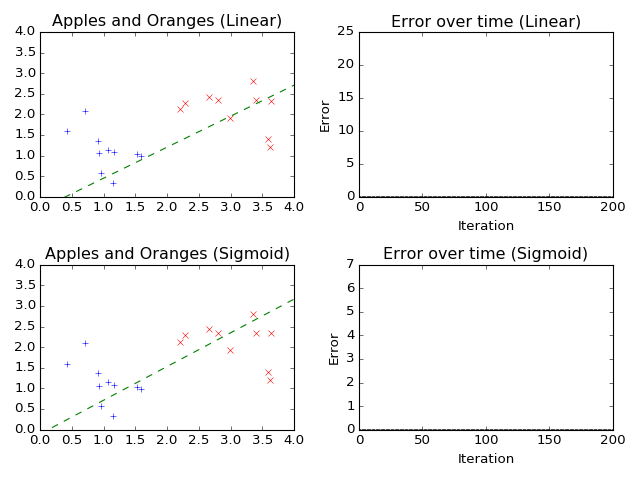

In [7]:
plotter.initPlotProb2()
optimizeSingle("Linear")
optimizeSingle("Sigmoid")

**YOUR TEXT HERE - Comment on the differences between the sigmoid and linear case.**

<h2 align="center">3. Multilayer network </h2> 

Augment the data from question 2 with the additional datasets apples2.npy and oranges2.npy. As you can see from plotting out the combined data, the problem of discriminating the apples from the oranges is no longer linearly separable, so we must use a multilayer network for this problem. Start by deriving the learning rules for a two layer network. Then, train a two-layer network (using backprop) to learn to discriminate between apples and oranges. Use the code below to get started. Experiment with adding a momentum term to see if it helps with convergence.

To make sure your solution works, we have provided you with a good initialization of the weights (goodInit=True). After you get this solution working you should experiment with random initializations (goodInit=False). In the description of your solution you should comment on the following:

a) From your learned solution, describe in words how the two layers work together to discriminate between apples and oranges. <br/>
b) The effect momentum has on the learning <br/>
c) The solutions learned when goodInit=False and why they happen <br/>

** Your LATEX here - Learning rules for a two-layer network **

In [ ]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from utils.lab2_utils import HyperPlanePlotter
import pdb

In [ ]:
# Additionally load 'data/apples2.mat' and 'data/oranges2.mat'
apples  = np.load('data/apples.npy')
oranges = np.load('data/oranges.npy')
apples2 = np.load('data/apples2.npy')                                                                                                                                      
oranges2 = np.load('data/oranges2.npy')

# initialize data array
apples = np.hstack((apples, apples2))
oranges = np.hstack((oranges, oranges2))
data = np.hstack((apples, oranges))
dimensions,numSamples = data.shape
halfNumSamples = int(numSamples/2)

In [ ]:
# initialize teacher
teacher = np.ones(numSamples)
teacher[halfNumSamples:] *= 0

# learning rate
eta=1e-1

# number of trials - you may want to make this smaller or larger
numTrials = 4000

# plotting
plotter = HyperPlanePlotter(data, apples, oranges, numTrials, halfNumSamples)
plotEvery  = numTrials // 50
plotErrorEvery = numTrials // 100

In [ ]:
def sigmoid(u):
    raise NotImplementedError ## YOUR CODE HERE

def sigmoidDeriv(u):
    raise NotImplementedError ## YOUR CODE HERE

In [20]:
def optimizeMulti(goodInit=True, momentum=False):
    # initialize weights and biases
    weightsOne = np.load('init/weightsOne.npy') if goodInit else np.random.randn(2,2) # first layer weights                                                                                                                                        
    biasOne    = np.load('init/biasOne.npy') if goodInit else np.random.randn(2,1)                                                                                                                                                                 
    weightsTwo = np.load('init/weightsTwo.npy') if goodInit else np.random.randn(2,1) # second layer weights                                                                                                                                       
    biasTwo    = np.load('init/biasTwo.npy') if goodInit else np.random.randn(1)                                                                                                                                                                   
     
    # setup plots
    plotter.setupPlotProb3(weightsOne, biasOne, weightsTwo, biasTwo)

    # initialize variables for momentum
    ## YOUR CODE HERE

    # loop over trials
    for t in range(numTrials):
        errorT = 0 
        # initialize derivative of weights, biases
        ## YOUR CODE HERE

        # loop over training set
        for i in range(numSamples):
            # forward pass - compute y layer
            # forward pass - compute z layer
            # compute error
            # accumulate second layer derivatives
            # accumulate first layer derivatives
            # accumulate the error according the objective function into errorT
            pass # YOUR CODE HERE
                
        # update weights and bias
        ## YOUR CODE HERE
        
        # track previous weight derivatives to use momentum
        ## YOUR CODE HERE

        # update display of separating hyperplane at plotEvery intervals
        if t % plotEvery == 0:
            plotter.updatePlotProb3(weightsOne, biasOne, weightsTwo, biasTwo)
        if t % plotErrorEvery == 0:
            plotter.plotErrorProb3(t, errorT)

In [ ]:
optimizeMulti(goodInit=True, momentum=False)

In [ ]:
optimizeMulti(goodInit=True, momentum=True)

In [ ]:
optimizeMulti(goodInit=False, momentum=True) # Run this many times

**YOUR TEXT HERE - Comment on the learned solution, the effect of momentum, and learned solution under random initializations** <br/>

<h2 align="center">4. Pattern Discrimination Task </h2> 

Consider the following pattern discrimination task:

![title](img/lab2.4.png)

In this problem you will train a two-layer network to discriminate between these two patterns. First, make a hypothesis about what representation the first layer will learn in order to allow the second layer to discriminate between these two patterns. Then, train a two-layer neural network to discriminate between these patterns. How many hidden units are needed? What representation is learned by the hidden units in order to solve this problem? Comment on the differences between how you thought to discriminate between the patterns and how the network learned to.

*** YOUR TEXT HERE -- Make a hypothesis about what representation the first layer will learn***

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from utils.lab2_utils import FilterPlotter
import pdb

In [2]:
# initialize data array
S = np.load('data/S.npy')
T = np.load('data/T.npy')
data = np.hstack((S,T))
numInputUnits,numSamples = data.shape
halfNumSamples = int(numSamples/2)

In [3]:
# initialize teacher
teacher = np.ones(numSamples)
teacher[halfNumSamples:] *= 0

# learning rate
eta=4e-1

# number of trials - you may want to make this smaller or larger
numTrials = 2000

# plotting
plotter = FilterPlotter(numTrials)
plotHiddenUnitsEvery  = numTrials // 20
plotErrorEvery = numTrials // 50

In [4]:
def sigmoid(u):
    raise NotImplementedError()

def sigmoidDeriv(u):
    raise NotImplementedError()

In [5]:
def optimizeMultiPattern(numHiddenUnits, momentum=False):
    # initialize weights and biases
    weightsOne = np.random.randn(numHiddenUnits, numInputUnits) # first layer weights                                                                                                                                        
    biasOne    = np.random.randn(numHiddenUnits,1)                                                                                                                                                                 
    weightsTwo = np.random.randn(numHiddenUnits,1) # second layer weights                                                                                                                                       
    biasTwo    = np.random.randn(1)                                                                                                                                                                
    
    plotter.setupPlots(weightsOne, numHiddenUnits)
        
    # initialize variables for momentum
    ## YOUR CODE HERE

    weightsOneDerivLast = 0; biasOneDerivLast = 0; weightsTwoDerivLast = 0; biasTwoDerivLast = 0
    # loop over trials
    for t in range(numTrials):
        # initialize derivative of weights, biases, and error array for each trial                                                                                                                                                                    
        errorT = 0  
        # loop over training set
        for i in range(numSamples):
            # forward pass
            # compute error
            # second layer derivatives 
            # first layer derivatives              
            # accumulate the error according the objective function into errorT
            pass ## YOUR CODE HERE
            
        # update weights and bias
        ## YOUR CODE HERE
        
        # track previous weight derivatives to use momentum
        ## YOUR CODE HERE
        
        # update display after plot*Every intervals
        if t % plotHiddenUnitsEvery == 0:
            plotter.updatePlots(weightsOne)
        if t % plotErrorEvery == 0:
            plotter.plotError(t, errorT)
    print ("Final Error: %.2f" % errorT)

In [ ]:
optimizeMultiPattern(numHiddenUnits=1, momentum=True) ## YOUR CODE HERE - Try different numbers of hidden units

*** YOUR TEXT HERE -- Comment on the number of hidden units needed and the differences between your hypothesis and results ***